In [ ]:
!pip install segmentation-models-pytorch albumentations kagglehub --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
import kagglehub
import os

DATA_PATH = kagglehub.dataset_download("iit23039maskeensingh/terrainnet")
print("Downloaded at:", DATA_PATH)


Using Colab cache for faster access to the 'terrainnet' dataset.
Downloaded at: /kaggle/input/terrainnet


In [ ]:
DATA_PATH = DATA_PATH + "/offroad-seg-kaggle"

print("Final Dataset Path:", DATA_PATH)
print(os.listdir(DATA_PATH))

Final Dataset Path: /kaggle/input/terrainnet/offroad-seg-kaggle
['train_images', 'train_masks', 'test_images']


In [ ]:
!pip install segmentation-models-pytorch


In [ ]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm

In [ ]:
class TerraDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, img_size=(540, 960)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_size = img_size  # H, W

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))  # width, height

        # Read mask
        mask = cv2.imread(self.mask_paths[idx], 0)
        mask = cv2.resize(mask, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]
            mask = aug["mask"].unsqueeze(0)  # shape: [1, H, W]

        return img, mask


In [ ]:
train_img_dir = os.path.join(DATA_PATH, "train_images")
train_mask_dir = os.path.join(DATA_PATH, "train_masks")

image_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])

print("Total Training Images:", len(image_paths))

Total Training Images: 3174


In [ ]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
train_transform = A.Compose([
    A.Resize(480,480),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.MotionBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(480,480),
    A.Normalize(),
    ToTensorV2()
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
train_dataset = TerraDataset(train_imgs, train_masks, train_transform)
val_dataset = TerraDataset(val_imgs, val_masks, val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = False)

In [ ]:
!pip install segmentation-models-pytorch --quiet

import torch
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    decoder_dropout=0.2
).to(device)

print("Using device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Using device: cuda


In [ ]:
import torch
import torch.nn as nn

dice_loss = smp.losses.DiceLoss(mode="binary")

bce_loss = nn.BCEWithLogitsLoss()

def loss_fn(preds, targets):
    return 0.5*bce_loss(preds, targets) + 0.5*dice_loss(preds, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",       # because we want IoU to increase
    factor=0.5,
    patience=2,

)





In [ ]:
def iou_score(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    return (intersection + 1e-6) / (union + 1e-6)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

def train_epoch(loader):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = model(imgs)
            loss = loss_fn(preds, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)


/tmp/ipython-input-3056899577.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
def validate(loader):
    model.eval()
    iou_total = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)
            iou_total += iou_score(preds, masks).item()

    return iou_total / len(loader)

In [ ]:
EPOCHS = 5
best_iou = 0
patience = 5
counter = 0



for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader)
    val_iou = validate(val_loader)

    scheduler.step(val_iou)

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation IoU: {val_iou:.4f}")

     # Early stopping
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break

  0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipython-input-3056899577.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 159/159 [05:12<00:00,  1.97s/it]



Epoch 1
Train Loss: 0.1131
Validation IoU: 0.9665


100%|██████████| 159/159 [04:10<00:00,  1.57s/it]



Epoch 2
Train Loss: 0.0742
Validation IoU: 0.9674


100%|██████████| 159/159 [04:08<00:00,  1.56s/it]



Epoch 3
Train Loss: 0.0632
Validation IoU: 0.9728


100%|██████████| 159/159 [04:08<00:00,  1.57s/it]



Epoch 4
Train Loss: 0.0594
Validation IoU: 0.9737


100%|██████████| 159/159 [04:09<00:00,  1.57s/it]



Epoch 5
Train Loss: 0.0563
Validation IoU: 0.9743


In [ ]:
print("Loading best saved model...")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


Loading best saved model...


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding

In [ ]:
import os
import glob
import cv2
import torch
import numpy as np
from tqdm import tqdm

# Paths
TEST_IMG_DIR = os.path.join(DATA_PATH, "test_images")  # Your test_images folder
PRED_MASK_DIR = "test_masks_padded"                    # Folder to save predicted grayscale masks
os.makedirs(PRED_MASK_DIR, exist_ok=True)

# Image size used during training
H, W = 540, 960  # or 256x256 if using resized images; we will resize later if needed

# Set model to evaluation mode
model.eval()

# List all test images
test_image_paths = sorted(glob.glob(os.path.join(TEST_IMG_DIR, "*.png")))
print("Total test images:", len(test_image_paths))

# Prediction loop
for p in tqdm(test_image_paths):
    # Read image
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to training size (if needed)
    img_resized = cv2.resize(img, (480,480))  # match your training transform
    img_resized = img_resized / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img_resized = (img_resized - mean) / std         # normalize to 0-1
    img_resized = np.transpose(img_resized, (2, 0, 1))  # HWC -> CHW
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict mask
    with torch.no_grad():
       pred1 = torch.sigmoid(model(img_tensor))

       # Flip image horizontally
       flipped = torch.flip(img_tensor, dims=[3])
       pred2 = torch.sigmoid(model(flipped))

       # Flip prediction back
       pred2 = torch.flip(pred2, dims=[3])

       # Average both predictions
       pred_mask = ((pred1 + pred2) / 2).squeeze().cpu().numpy() # 0-1 probability

       # Resize mask back to original size
       pred_mask_resized = cv2.resize(pred_mask, (W, H), interpolation=cv2.INTER_NEAREST)

       # Convert to 0-255 grayscale
       pred_mask_gray = (pred_mask_resized * 255).astype(np.uint8)

       # Save predicted mask
       out_path = os.path.join(PRED_MASK_DIR, os.path.basename(p))
       cv2.imwrite(out_path, pred_mask_gray)

print("Predicted masks saved to:", PRED_MASK_DIR)


Total test images: 1002


100%|██████████| 1002/1002 [01:52<00:00,  8.88it/s]

Predicted masks saved to: test_masks_padded


In [ ]:
import os, glob
import cv2
import numpy as np

IN_DIR  = "test_masks_padded"        # your original grayscale masks
OUT_DIR = "binary_masks_27_39"       # output binary masks (0/255)

os.makedirs(OUT_DIR, exist_ok=True)

paths = sorted(glob.glob(os.path.join(IN_DIR, "*.png")))
print("Found masks:", len(paths))

THRESHOLD = 127  # any pixel >127 becomes foreground

for p in paths:
    m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if m is None:
        print("Skip unreadable:", p)
        continue

    # Convert to binary mask
    b01 = (m > THRESHOLD).astype(np.uint8)

    # Save as 0/255
    out_path = os.path.join(OUT_DIR, os.path.basename(p))
    cv2.imwrite(out_path, b01*255)


print("Done. Binary masks saved to:", OUT_DIR)

# sanity check on one file
if paths:
    sample = cv2.imread(os.path.join(OUT_DIR, os.path.basename(paths[0])), cv2.IMREAD_GRAYSCALE)
    print("Sample unique values in saved binary mask:", np.unique(sample))


Found masks: 1002
Done. Binary masks saved to: binary_masks_27_39
Sample unique values in saved binary mask: [  0 255]


In [ ]:
import os, glob
import cv2
import numpy as np
import pandas as pd

MASK_DIR = "binary_masks_27_39"   # ✅ Output from previous block
OUT_CSV  = "submission.csv"       # or solution.csv

H, W = 540, 960   # image size

def rle_encode(mask01):
    pixels = mask01.flatten(order="F")
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

rows = []
paths = sorted(glob.glob(os.path.join(MASK_DIR, "*.png")))
print("Found binary masks:", len(paths))

for p in paths:
    m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if m is None:
        print("Skip unreadable:", p)
        continue

    if m.shape != (H, W):
        raise ValueError(f"{p} has shape {m.shape}, expected {(H,W)}")

    mask01 = (m > 127).astype(np.uint8)  # 0/255 -> 0/1
    rle = rle_encode(mask01)

    image_id = os.path.splitext(os.path.basename(p))[0]
    rows.append({"image_id": image_id, "encoded_pixels": rle})

df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

Found binary masks: 1002
Saved: submission.csv


In [ ]:
print(np.unique(m))

In [ ]:
print(np.unique(mask01))

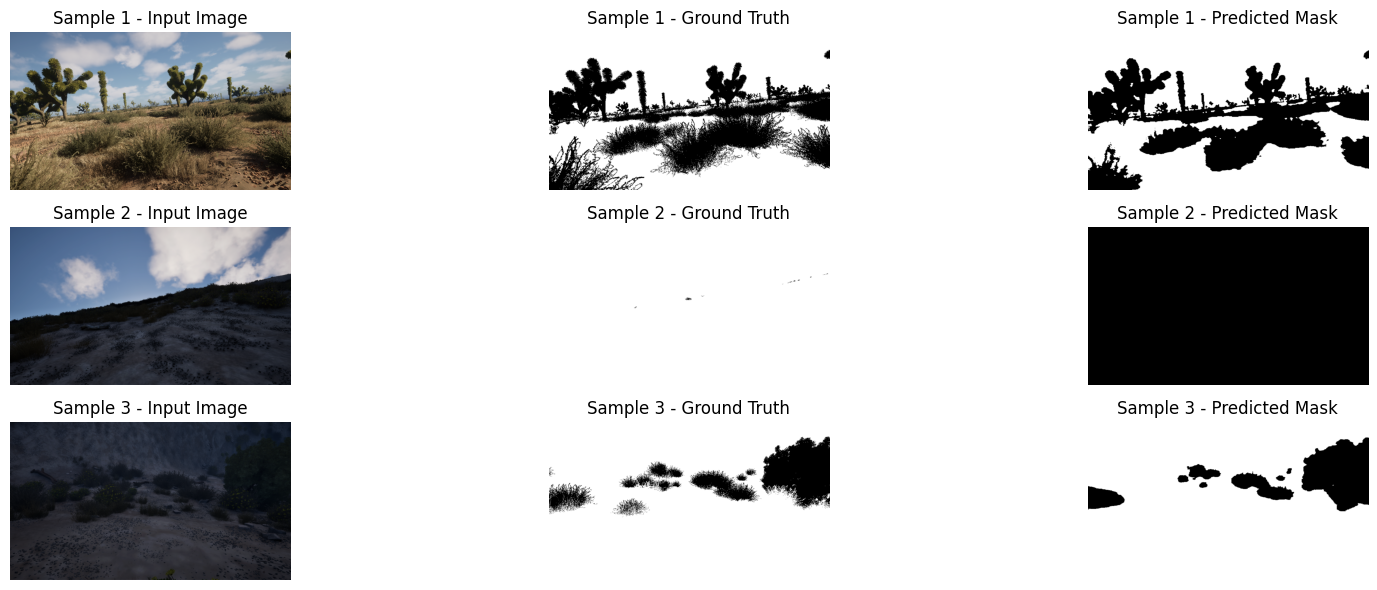

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import cv2

# Set model to evaluation mode
model.eval()

# Select a few random indices from the validation dataset
num_samples = 3
random_indices = random.sample(range(len(val_dataset)), num_samples)

plt.figure(figsize=(18, 6))

for i, idx in enumerate(random_indices):
    # Get original image and ground truth mask from the dataset (before transform for visualization)
    original_img_path = val_dataset.image_paths[idx]
    original_mask_path = val_dataset.mask_paths[idx]

    original_img_np = cv2.imread(original_img_path)
    original_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_BGR2RGB)

    ground_truth_mask_np = cv2.imread(original_mask_path, 0)
    ground_truth_mask_np = (ground_truth_mask_np > 0).astype(np.float32) * 255 # Convert to 0/255 for display

    # Get transformed image for model prediction
    img_tensor = val_dataset[idx][0].unsqueeze(0).to(device) # Add batch dimension and move to device

    # Generate prediction
    with torch.no_grad():
        prediction = model(img_tensor)

    # Process prediction: sigmoid, threshold, and convert to numpy
    predicted_mask = torch.sigmoid(prediction).squeeze().cpu().numpy()
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8) * 255 # Convert to 0/255 for display

    # Resize predicted mask to original image size (H, W are 540, 960 from previous cell)
    predicted_mask_resized = cv2.resize(predicted_mask, (W, H), interpolation=cv2.INTER_NEAREST)

    # Display original image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(original_img_np)
    plt.title(f'Sample {i+1} - Input Image')
    plt.axis('off')

    # Display ground truth mask
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(ground_truth_mask_np, cmap='gray')
    plt.title(f'Sample {i+1} - Ground Truth')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(predicted_mask_resized, cmap='gray')
    plt.title(f'Sample {i+1} - Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

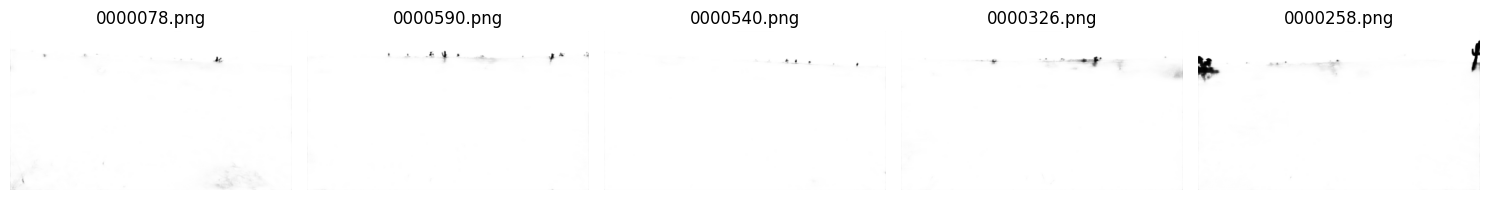

In [ ]:
import matplotlib.pyplot as plt
import random
import os

# Get a list of all predicted mask files
predicted_mask_files = glob.glob(os.path.join(PRED_MASK_DIR, '*.png'))

# Select a few random masks to display
num_samples = 5
sample_masks = random.sample(predicted_mask_files, min(num_samples, len(predicted_mask_files)))

plt.figure(figsize=(15, 5))
for i, mask_path in enumerate(sample_masks):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, len(sample_masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(os.path.basename(mask_path))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import torch

# 1️⃣ Define a Dataset class for your test images
class TestDataset(Dataset):
    def __init__(self, image_paths, img_size=(540,960)):
        self.image_paths = image_paths
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # scale to 0-1
        img = img.astype(np.float32)
        img = self.transform(img)
        return img

# 2️⃣ Create Dataset and DataLoader
test_dataset = TestDataset(test_image_paths, img_size=(480,480))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
model.eval()

output_dir = "predicted_masks"
os.makedirs(output_dir, exist_ok=True)

total_masks_saved = 0
current_image_idx = 0

with torch.no_grad():
    for imgs in tqdm(test_loader, desc="Generating masks"):
        imgs = imgs.to(device)

        preds = model(imgs)

        binary_preds = torch.sigmoid(preds)
        binary_preds = (binary_preds > 0.5).float()

        for i in range(binary_preds.shape[0]):
            mask_np = binary_preds[i].cpu().numpy().squeeze()

            # Resize to original image dimensions (H, W are 540, 960 from previous cell)
            resized_mask = cv2.resize(mask_np, (W, H), interpolation=cv2.INTER_NEAREST)
            final_mask = (resized_mask * 255).astype(np.uint8)

            original_image_path = test_image_paths[current_image_idx]
            image_filename = os.path.basename(original_image_path)
            output_mask_filename = os.path.join(output_dir, image_filename)

            cv2.imwrite(output_mask_filename, final_mask)
            total_masks_saved += 1
            current_image_idx += 1

print(f"Done. Generated and saved {total_masks_saved} predicted masks to: {output_dir}")

Generating masks: 100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

Done. Generated and saved 1002 predicted masks to: predicted_masks


In [ ]:
from tensorflow.keras import layers, models

def unet(input_shape=(256,256,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.UpSampling2D((2,2))(b1)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2,2))(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c4)
    model = models.Model(inputs, outputs)
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
